In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import des_functions as des
from more_itertools import locate

datdir = '/home/b7009348/WGL_project/DES-data/'
matched = 'y1_mcal_shapes_matched.fits'
full = 'y1_mcal_flags=0.fits'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [3]:
with fits.open(datdir+full) as hdu:
    data = hdu[1].data
    fullsize = data['size']
    psf = data['psf_size']
    mcalid = data['coadd_objects_id']
    e1_full = data['e1']
    r11_full = data['R11']
    full_eff_size = fullsize/psf

with fits.open(datdir+matched) as hdu:
    data = hdu[1].data
    match_ids = data['coadd_objects_id']
    matchsize = data['size']
    psf = data['psf_size']
    match_eff_size = matchsize/psf
    r11_match = data['R11']
    
print(np.size(full_eff_size))
print(np.size(match_eff_size))
del data, psf

34839418
17814587


In [4]:
print(fullsize.min())
print(matchsize.min())
print(match_eff_size.min())
print(full_eff_size.min())

0.11281747512670545
0.12199357245264765
0.45750278564715213
0.09088260563731322


In [5]:
eff_size = 3
indexes = list(locate(full_eff_size, lambda x: x >= eff_size))
cut_eff = full_eff_size[indexes]
cut_mcalid = mcalid[indexes]

In [6]:
print(np.size(cut_eff))

with fits.open(datdir+'y1_im3_flags=0.fits') as hdu:
    data = hdu[1].data
    im3ids = data['coadd_objects_id']

matches, mcal_indexes, im3_indexes = np.intersect1d(cut_mcalid, im3ids, return_indices=True)

print(np.size(matches))

2996320
1330834


In [7]:
with fits.open(datdir+full) as hdu:
    data = hdu[1].data
    full_snr = data['snr']
    full_size = data['size']
    full_rflux = data['flux_r']
    full_ids = data['coadd_objects_id']
del data

print('locating r-band cut...')
indexes = list(locate(full_rflux, lambda x: 445. <= x))
print('indexes located, cutting...')

size = full_size[indexes]
removed  = np.size(full_rflux)-np.size(size)
snr = full_snr[indexes]
rflux = full_rflux[indexes]
cut_ids = full_ids[indexes]

print(np.size(rflux), 'removed:', removed)

print('locating size cut...')
indexes = list(locate(size, lambda x: 0.325 <= x))
print('indexes located, cutting...')


size = size[indexes]
removed  = np.size(rflux)-np.size(size)
snr = snr[indexes]
rflux = rflux[indexes]
cut_ids = full_ids[indexes]

print(np.size(size), 'removed:', removed)

print('locating S/N cut...')
indexes = list(locate(snr, lambda x: 16.8 <= x))
print('indexes located, cutting...')

size = size[indexes]
removed  = np.size(rflux)-np.size(size)
snr = snr[indexes]
rflux = rflux[indexes]
cut_ids = full_ids[indexes]

print(np.size(snr), 'removed:', removed)
      
del indexes, removed, size, snr, rflux, full_rflux, full_snr, full_size

locating r-band cut...
indexes located, cutting...
29171131 removed: 5668287
locating size cut...
indexes located, cutting...
23533155 removed: 5637976
locating S/N cut...
indexes located, cutting...
17844302 removed: 5688853


In [8]:
# similarity test to matched catalogue

matches, cut_indi, match_indi = np.intersect1d(cut_ids, match_ids, return_indices=True)

print(np.size(matches)/np.size(match_ids)*100)

52.997276894491016


### Now we've assertained the limits to yield similar sized cuts with a final catalogue similar to the matched one, we can create try and find the selection bias

In [9]:
min_snr = 16.8
min_size = 0.325
min_rflux = 445.

In [10]:
with fits.open(datdir+full) as hdu:
    data = hdu[1].data
    snr = data['snr']
    size = data['size']
    rflux = data['flux_r']
    R11 = data['R11']
    R22 = data['R22']
    ra_s = data['RA']
    dec_s = data['DEC']
    e1_s = data['e1']
    e2_s = data['e2']
del data
# start by finding the cut on unsheared data

print('locating cut on r-band flux...')
indexes = list(locate(rflux, lambda x: min_rflux <= x))
print('slicing data...')
R11 = R11[indexes]
R22 = R22[indexes]
ra_s = ra_s[indexes]
dec_s = dec_s[indexes]
e1_s = e1_s[indexes]
e2_s = e2_s[indexes]
snr = snr[indexes]
size = size[indexes]
print('removed:', np.size(rflux)-np.size(R11))
del rflux


print('locating cut on size...')
indexes = list(locate(size, lambda x: min_size <= x))
print('slicing data...')
R11 = R11[indexes]
R22 = R22[indexes]
ra_s = ra_s[indexes]
dec_s = dec_s[indexes]
e1_s = e1_s[indexes]
e2_s = e2_s[indexes]
snr = snr[indexes]
print('removed:', np.size(size)-np.size(R11))
del size


print('locating cut on S/N...')
indexes = list(locate(snr, lambda x: min_snr <= x))
print('slicing data...')
R11 = R11[indexes]
R22 = R22[indexes]
ra_s = ra_s[indexes]
dec_s = dec_s[indexes]
e1_s = e1_s[indexes]
e2_s = e2_s[indexes]
print('removed:', np.size(snr)-np.size(R11))
del snr


print('Final data size:', np.size(R11))
print('Computing Ry')

Ry11 = np.mean(R11)
Ry22 = np.mean(R22)

print('Ry11:', Ry11, 'Ry22:', Ry22)
del R11, R22, indexes

locating cut on r-band flux...
slicing data...
removed: 5668287
locating cut on size...
slicing data...
removed: 5637976
locating cut on S/N...
slicing data...
removed: 5688853
Final data size: 17844302
Computing Ry
Ry11: 0.7470308114095333 Ry22: 0.7489749542295671


In [11]:
# next we find the selection responses...
with fits.open(datdir+full) as hdu:
    data = hdu[1].data
    snr_1p = data['snr_1p']
    size_1p = data['size_1p']
    rflux_1p = data['flux_r_1p']
    e1 = data['e1']
del data
    
print('Initialising selections for e1 postive sheared')

print('locating cut on 1p S/N...')
indexes = list(locate(snr_1p, lambda x: min_snr <= x))
print('slicing data...')
e1 = e1[indexes]
rflux_1p = rflux_1p[indexes]
size_1p = size_1p[indexes]
del snr_1p

print('locating cut on 1p size...')
indexes = list(locate(size_1p, lambda x: min_size <= x))
print('slicing data...')
e1 = e1[indexes]
rflux_1p = rflux_1p[indexes]
del size_1p

print('locating cut on 1p r-band flux...')
indexes = list(locate(rflux_1p, lambda x: min_rflux <= x))
print('slicing data...')
e1 = e1[indexes]
del rflux_1p

avg_e1_s1p = np.mean(e1)
print('Final data size:',np.size(e1))
print('Mean <e1>S+:',avg_e1_s1p)

del indexes

Initialising selections for e1 postive sheared
locating cut on 1p S/N...
slicing data...
locating cut on 1p size...
slicing data...
locating cut on 1p r-band flux...
slicing data...
Final data size: 17843040
Mean <e1>S+: 0.0003862996037292233


In [12]:
# next we find the selection responses...
with fits.open(datdir+full) as hdu:
    data = hdu[1].data
    snr_1m = data['snr_1m']
    size_1m = data['size_1m']
    rflux_1m = data['flux_r_1m']
    e1 = data['e1']
del data
    
print('Initialising selections for e1 negative sheared')
print('locating cut on 1m S/N...')
indexes = list(locate(snr_1m, lambda x: min_snr <= x))
print('slicing data...')
e1 = e1[indexes]
size_1m = size_1m[indexes]
rflux_1m = rflux_1m[indexes]
del snr_1m

print('locating cut on 1m size...')
indexes = list(locate(size_1m, lambda x: min_size <= x))
print('slicing data...')
e1 = e1[indexes]
rflux_1m = rflux_1m[indexes]
del size_1m

print('locating cut on 1m r-band flux...')
indexes = list(locate(rflux_1m, lambda x: min_rflux <= x))
print('slicing data...')
e1 = e1[indexes]
del rflux_1m

avg_e1_s1m = np.mean(e1)
print('Final data size:',np.size(e1))
print('Mean <e1>S-:',avg_e1_s1m)

del indexes

Initialising selections for e1 negative sheared
locating cut on 1m S/N...
slicing data...
locating cut on 1m size...
slicing data...
locating cut on 1m r-band flux...
slicing data...
Final data size: 17843410
Mean <e1>S-: 0.0001500149984111462


In [13]:
# next we find the selection responses...
with fits.open(datdir+full) as hdu:
    data = hdu[1].data
    snr_2m = data['snr_2m']
    size_2m = data['size_2m']
    rflux_2m = data['flux_r_2m']
    e2 = data['e2']
del data
    
print('Initialising selections for e2 negative sheared')
print('locating cut on 2m S/N...')
indexes = list(locate(snr_2m, lambda x: min_snr <= x))
print('slicing data...')
e2 = e2[indexes]
size_2m = size_2m[indexes]
rflux_2m = rflux_2m[indexes]
del snr_2m

print('locating cut on 2m size...')
indexes = list(locate(size_2m, lambda x: min_size <= x))
print('slicing data...')
e2 = e2[indexes]
rflux_2m = rflux_2m[indexes]
del size_2m

print('locating cut on 1m r-band flux...')
indexes = list(locate(rflux_2m, lambda x: min_rflux <= x))
print('slicing data...')
e2 = e2[indexes]
del rflux_2m

avg_e2_s2m = np.mean(e2)
print('Final data size:',np.size(e2))
print('Mean <e2>S-:',avg_e2_s2m)

del indexes

Initialising selections for e2 negative sheared
locating cut on 2m S/N...
slicing data...
locating cut on 2m size...
slicing data...
locating cut on 1m r-band flux...
slicing data...
Final data size: 17842856
Mean <e2>S-: 7.282595837300564e-05


In [14]:
# next we find the selection responses...
with fits.open(datdir+full) as hdu:
    data = hdu[1].data
    snr_2p = data['snr_2p']
    size_2p = data['size_2p']
    rflux_2p = data['flux_r_2p']
    e2 = data['e2']
del data
    
print('Initialising selections for e2 negative sheared')
print('locating cut on 2p S/N...')
indexes = list(locate(snr_2p, lambda x: min_snr <= x))
print('slicing data...')
e2 = e2[indexes]
size_2p = size_2p[indexes]
rflux_2p = rflux_2p[indexes]
del snr_2p

print('locating cut on 2m size...')
indexes = list(locate(size_2p, lambda x: min_size <= x))
print('slicing data...')
e2 = e2[indexes]
rflux_2p = rflux_2p[indexes]
del size_2p

print('locating cut on 1m r-band flux...')
indexes = list(locate(rflux_2p, lambda x: min_rflux <= x))
print('slicing data...')
e2 = e2[indexes]
del rflux_2p

avg_e2_s2p = np.mean(e2)
print('Final data size:',np.size(e2))
print('Mean <e2>S+:',avg_e2_s2p)

del indexes

Initialising selections for e2 negative sheared
locating cut on 2p S/N...
slicing data...
locating cut on 2m size...
slicing data...
locating cut on 1m r-band flux...
slicing data...
Final data size: 17842857
Mean <e2>S+: 0.00030694039481451627


In [15]:
match_counts, match_bins = np.histogram(e1, bins=1000)
full_counts, full_bins = np.histogram(e1_full, bins=1000)

#normalise to get probability dist.
match_pdf = match_counts / np.size(e1)
full_pdf = full_counts / np.size(e1_full)

In [16]:
def kl_divergence(p, q):
    """
    Computes the Kullback-Leibler divergence between two distributions p and q.
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = np.where(p != 0, p, np.finfo(float).eps)
    q = np.where(q != 0, q, np.finfo(float).eps)
    kl_div = np.sum(np.where(p != 0, p * np.log(p / q), 0))
    return kl_div

kl_divergence(match_pdf, full_pdf)

0.0032538635609135214

In [17]:
# Now we can compute the selection response
delGam = 0.01
Rs11 = (avg_e1_s1p - avg_e1_s1m) / delGam
Rs22 = (avg_e2_s2p - avg_e2_s2m) / delGam

print('Ry11:',Ry11,'Ry22:',Ry22)
print('Rs11:',Rs11,'Rs22:',Rs22)
print('R11:',Ry11+Rs11,'R22:',Ry22+Rs22)

Ry11: 0.7470308114095333 Ry22: 0.7489749542295671
Rs11: 0.02362846053180771 Rs22: 0.023411443644151063
R11: 0.770659271941341 R22: 0.7723863978737181


Now lets try and compute some MCAL tangential shears using the different response values

- Consider e1 and e2 unsheared
- In one case we will use Ry+Rs, in the other we will just use Ry
- R11 ~ R22 so we will just use R11 for this anylsis (I think this is what is done in DES Y1)

In [18]:
import treecorr
lens_file = 'DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits'
rand_file = 'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits'

Ry11 = 0.7470308114095333 
Rs11 = 0.02362846053180771

In [19]:
with fits.open(datdir+lens_file) as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
del data
    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', 
                         dec_units='deg', w=w_l)

del ra_l, dec_l, w_l
                         
with fits.open(datdir+rand_file) as hdu:
    data = hdu[1].data
    ra_r = data['RA']
    dec_r = data['DEC']
del data

cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', 
                         dec_units='deg')

del ra_r, dec_r

cat_mcalCut = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg',
                          dec_units='deg', g1=e1_s, g2=e2_s)

gamma_Ry, theta = des.mcal_tang_shear(cat_l, cat_mcalCut, cat_r,
                                      Ry11, 10, 2.5, 250.)

gamma_RyRs, theta = des.mcal_tang_shear(cat_l, cat_mcalCut, cat_r,
                                      Ry11+Rs11, 10, 2.5, 250.)

Text(0.5, 1.0, 'All lenses, S/N + r-band + size selection')

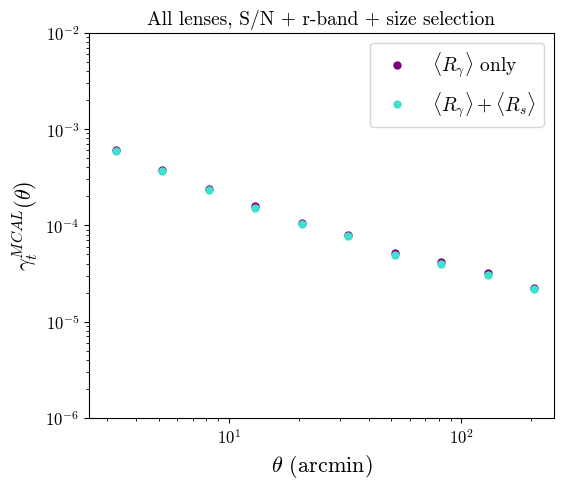

In [20]:
plt.figure(figsize=[6,5])
plt.plot(theta, gamma_Ry, lw=0., marker='o', color ='purple',markersize=5)
plt.plot(theta, gamma_RyRs, lw=0., marker='o', color='turquoise', markersize=5)
plt.yscale('log')
plt.xscale('log')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)', fontsize=16)
plt.ylabel(r'$\gamma_{t}^{MCAL}(\theta)$', fontsize=16)
plt.legend([r'$\langle R_{\gamma} \rangle$ only', r'$\langle R_{\gamma} \rangle + \langle R_{s} \rangle$'], fontsize=14)
plt.title('All lenses, S/N + r-band + size selection', fontsize=14)

In [21]:
diff = gamma_Ry - gamma_RyRs
print(diff)

[1.86604277e-05 1.15365157e-05 7.37264433e-06 4.81941664e-06
 3.24334323e-06 2.43693109e-06 1.56456569e-06 1.26168937e-06
 9.74208093e-07 6.85927059e-07]


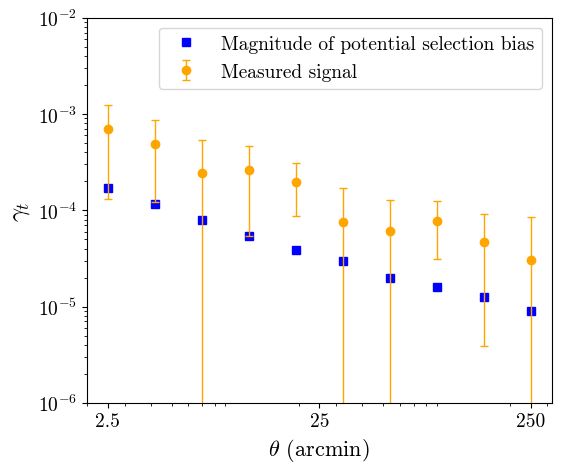

In [26]:
real_values = np.load(datdir+'multiia_full-bin_slop=0.1.npz')
jackknife_values = np.load(datdir+'multiia_jackknife-bin_slop=0.1.npz')
IA = real_values['IA']
B = real_values['boost']
F = real_values['F']

theta = np.logspace(np.log10(2.5), np.log10(250), 10)

selection_shift = diff / (B-1.+F)

plt.figure(figsize=[6,5])
plt.plot(theta, selection_shift, linewidth=0, marker='s', color='blue')
plt.errorbar(theta, real_values['IA'], yerr=np.sqrt(np.diag(jackknife_values['IA_cov'])), linewidth=0, marker='o', elinewidth=1, capsize=3, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.xticks([2.5,25,250],['2.5','25','250'],fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([1e-6, 1e-2])
plt.ylabel(r'$\gamma_{t}$', fontsize=18)
#plt.ylabel(r'$(1-a)\bar{\gamma}_{IA}(\theta)$', fontsize=16)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=16)
#plt.title(r'All lenses', fontsize=18)
plt.legend([r'Magnitude of potential selection bias', 
            r'Measured signal'], fontsize=14)
plt.savefig('IA_vs_selection.pdf',bbox_inches='tight',dpi=300)

In [23]:
print(selection_shift)

[1.72398501e-04 1.17365656e-04 7.99896844e-05 5.47153881e-05
 3.83130579e-05 2.96587629e-05 1.95784909e-05 1.60777252e-05
 1.26697805e-05 9.00903309e-06]


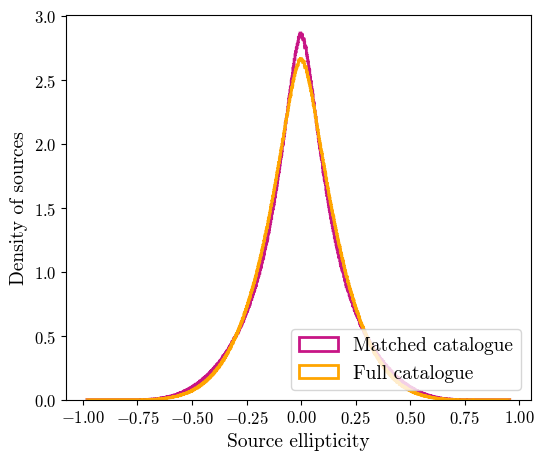

In [24]:
nbins = 1000

plt.figure(figsize=[6,5])
plt.hist(e1, bins=nbins, color='mediumvioletred', density=True, histtype='step', linewidth=2)
plt.hist(e1_full, bins=nbins, color='orange', density=True, histtype='step', linewidth=2)
plt.legend(['Matched catalogue', 'Full catalogue'], loc=4, fontsize=14)
plt.ylabel('Density of sources', fontsize=14)
plt.xlabel('Source ellipticity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('mcal_ellipticity_dist.png', dpi=300)

In [25]:
0.0032538635609135214 / 0.0015508527092138284

2.0981125683837494